In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

import numpy as np
import ot as pot
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.tensorboard import SummaryWriter

import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from models_v2 import *
from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler

import scipy as sp

from tqdm import tqdm

from multiprocessing import Pool

import imageio

from utils_hf import *
savedir = "models/obs_gauss_gauss"
os.makedirs(savedir, exist_ok=True)



In [5]:
alpha = 5/2
beta = 2
def r(x, plot = False):
    if plot:
        return np.linalg.norm(x, axis=-1)**2
    else:
        return (np.linalg.norm(x, axis=-1)**2)

def obstacle(x,plot = False):
    exp_inv = np.exp(-alpha*(r(x)-.5))#[:,None]
    return -beta*exp_inv/(1+exp_inv)   

def obstacle_grad(x):
    # print(x)
    exp_inv = np.exp(-alpha*(r(x)-.5))[:,None]
    return 2*beta*alpha*(exp_inv)*(1/(1+exp_inv)**2)*x

def grad_pot(x):
    exp_inv = np.exp(-alpha*(r(x)-.5))
    return 2*beta*alpha*(exp_inv)*(1/(1+exp_inv)**2)*x
    

In [3]:
x = np.linspace(-1.5,1.5,100)
y = np.linspace(-1.5,1.5,100)
X,Y = np.meshgrid(x,y)
Z = obstacle(np.stack([X,Y],axis=-1),True).reshape(100,100)



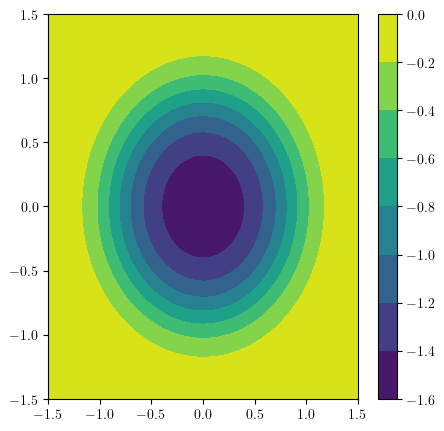

In [4]:
plt.figure(figsize=(5,5))
plt.contourf(X,Y,Z)
plt.colorbar()

In [37]:
# Dynamics for mean and std

def f(t,x):
    # x = [mu, mu',sigma,sigma']
    mu = x[:2]
    mu_p = x[2:4]
    sigma = x[4]
    sigma_p = x[5]
    mesh_elements = x.shape[1]
    result = np.zeros_like(x)
    samples_gauss = np.random.randn(10_000,2)
    
    for i in range(mesh_elements):
        mu_i = mu[:,i]
        mu_p_i = mu_p[:,i]
        sigma_i = sigma[i]
        sigma_p_i = np.array([sigma_p[i]])        
        samples = sigma_i*samples_gauss+mu_i
        eval_grad = obstacle_grad(samples)
        mu_pp = np.mean(eval_grad,axis=0)
        dot_produtc = np.einsum('bi,bi->b',eval_grad,samples_gauss)
        sigma_pp = 1*np.array([np.mean(dot_produtc,axis=0)])
        res = np.concatenate([mu_p_i,-mu_pp,sigma_p_i,-sigma_pp])
        result[:,i] = res
    
    return result

def f_mu(t,x):
    # x = [mu, mu']
    x1 = x[:2]
    x2 = x[2:4]
    
    mesh_elements = x.shape[1]
    result = np.zeros_like(x)
    for i in range(mesh_elements):
        x1_i = x1[:,i]
        x2_i = x2[:,i]
        x2_p  = -grad_pot(x1_i)
        x1_p = x2_i
        # print(x1_p,x2_p)
        res = np.concatenate([x1_p,x2_p])
        result[:,i] = res
    return result

def f_std(t,x,mu):
    #x:  [sigma,sigma']
    #mu: function of t that returns mu
    sigma = x[:1]
    sigma_p = x[1:2]
    samples_gauss = np.random.randn(10_000,2)
    sigma_i = sigma
    sigma_p_i = sigma_p       
    samples = sigma_i*samples_gauss+mu(t)
    eval_grad = obstacle_grad(samples)
    dot_produtc = np.einsum('bi,bi->b',eval_grad,samples_gauss)
    sigma_pp = 1*np.array([np.mean(dot_produtc,axis=0)])
    # print(sigma_p_i,-sigma_pp)
    res = np.concatenate([sigma_p_i,-sigma_pp])
    return res


def solve_bvp(args):
    i,x0, x1, t = args
    # Define mean of Gaussian distributions
    mu_0 = x0
    mu_1 = x1
    sigma_0 = np.array([0.1])
    sigma_1 = np.array([0.1])
    x = np.linspace(0,1,10)
    y = np.full((6,x.shape[0]),0.00)
    

    # Solve BVP for Gaussians
    bc = lambda ya,yb: np.concatenate([ya[:2]-mu_0,yb[:2]-mu_1,ya[4]-sigma_0,yb[4]-sigma_1])
    sol = sp.integrate.solve_bvp(f,bc,x,y,tol = 1e-1,max_nodes=20)
    eval =sol.sol(t)

    mu_t = np.squeeze(eval[:2])
    mu_p_t = np.squeeze(eval[2:4])
    sigma_t = np.squeeze(eval[4])
    sigma_p_t = np.squeeze(eval[5])


    return mu_t, mu_p_t, sigma_t, sigma_p_t

In [44]:



def dynam_mu_sig(t,x0,x1,bs):
    '''
    Input:
        t:    (bs,)
        mu_0: (bs,2)
        mu_1: (bs,2)
    ---------------------------------------
    Output:
        mu:   (bs,2)
        mu':  (bs,2)
        sig:  (bs,)
        sig': (bs,)
    '''
    sigma_0 = np.array([.001])
    sigma_1 = np.array([.001])
    N = 10
    x = np.linspace(0,1,N)
    y = np.full((6,x.shape[0]),0.00)

    mu_t = np.zeros((bs,2))
    mu_p_t = np.zeros((bs,2))
    sigma_t = np.zeros((bs,))
    sigma_p_t = np.zeros((bs,))

    for i in range(bs):

        # Define mean of Gaussian distributions
        mu_0 = x0[i]
        mu_1 = x1[i]
        # Solve BVP for Gaussians

        bc = lambda ya,yb: np.concatenate([ya[:2]-mu_0,yb[:2]-mu_1,ya[4]-sigma_0,yb[4]-sigma_1])
        
        sol = sp.integrate.solve_bvp(f,bc,x,y,tol = 1e-1,max_nodes=20)#,verbose=2)
        eval =sol.sol(t[i])
        
        mu_t[i] = np.squeeze(eval[:2])
        mu_p_t[i] = np.squeeze(eval[2:4])
        sigma_t[i] = np.squeeze(eval[4])
        sigma_p_t[i] = np.squeeze(eval[5])

    return mu_t,mu_p_t,sigma_t,sigma_p_t

def dynam_mu_sig2(t,x0,x1,bs):
    '''
    Input:
        t:    (bs,)
        mu_0: (bs,2)
        mu_1: (bs,2)
    ---------------------------------------
    Output:
        mu:   (bs,2)
        mu':  (bs,2)
        sig:  (bs,)
        sig': (bs,)
    '''
    # sigma_0 = np.array([.1])
    # sigma_1 = np.array([.001])
    y0_std = np.array([0.1,0])
    N = 10
    x = np.linspace(0,1,N)
    y_mu = np.full((4,x.shape[0]),0.00)

    mu_t = np.zeros((bs,2))
    mu_p_t = np.zeros((bs,2))
    sigma_t = np.zeros((bs,))
    sigma_p_t = np.zeros((bs,))

    for i in range(bs):

        # Define mean of Gaussian distributions
        mu_0 = x0[i]
        mu_1 = x1[i]
        # Solve BVP for Gaussians

        bc_mu = lambda ya,yb: np.concatenate([ya[:2]-mu_0,yb[:2]-mu_1])
        
        sol_mu = sp.integrate.solve_bvp(f_mu,bc_mu,x,y_mu,tol = 1e-2)#,verbose=2)
        sol_sig = sp.integrate.solve_ivp(f_std,[0,t[i][0]],y0_std,method = 'RK23',t_eval=[t[i][0]],args=(lambda t: sol_mu.sol(t)[:2],))

        eval_mu =sol_mu.sol(t[i])
        # eval_sig =sol_sig.sol(t[i])
        
        mu_t[i] = np.squeeze(eval_mu[:2])
        mu_p_t[i] = np.squeeze(eval_mu[2:4])
        sigma_t[i] = np.squeeze(sol_sig.y[0])
        sigma_p_t[i] = np.squeeze(sol_sig.y[1])

    return mu_t,mu_p_t,sigma_t,sigma_p_t




In [45]:
def eval_hamiltonian(mu,mu_p,sig,sig_p):
    '''
    See (3.18) PWHF
    '''
    '''
    mu: [2,N]
    mu_p: [2,N]
    sig: [1,N]
    sig_p: [1,N]
    '''
    N = mu.shape[1]
    
    res = np.zeros(N)
    kinetic_mu = np.linalg.norm(mu_p, axis=0)**2/2
    kinetic_sig = sig_p**2/2
    kinetic = kinetic_mu + kinetic_sig
    
    for i in range(N):
        mu_i = mu[:,i]
        sigma_i = sig[i]
        samples_gauss = np.random.randn(200_000,2)    
        samples = sigma_i*samples_gauss+mu_i 
        eval_obstacle = obstacle(samples,True)
        res[i] = np.mean(eval_obstacle)
    return kinetic + res

    

In [46]:
use_cuda = torch.cuda.is_available()
device = 'cpu'#torch.device("cuda" if use_cuda else "cpu")
# Problem set up

dim = 2
batch_size = 50
n_iters = 10_500
architecture = 'MLP'
ot_sampler = OTPlanSampler(method="exact")

In [47]:
if architecture == 'ResNet':
    model = ResNet(dim= dim,w=64,time_varying= True).to(device)
else: 
    model = MLP(dim= dim,w=64,time_varying= True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [48]:
# Set up initial and target distributions

mu_0 = torch.tensor([-2.0,0.0])
mu_1 = torch.tensor([2.0,0.0])
sigma_0 = torch.tensor([1])
sigma_1 = torch.tensor([1])

mu = MultivariateNormal(mu_0, torch.eye(2)*sigma_0)
nu = MultivariateNormal(mu_1, torch.eye(2)*sigma_1)


  0%|          | 0/10500 [00:00<?, ?it/s]

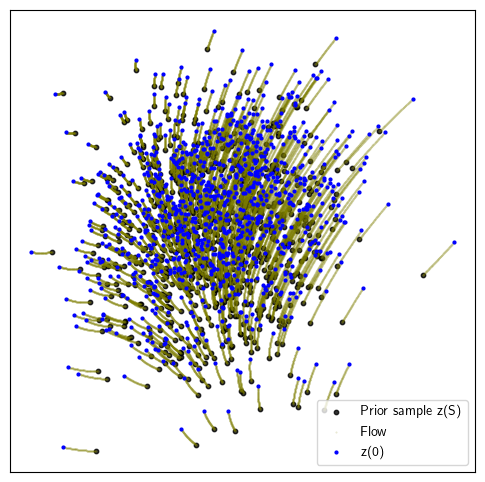

  5%|▍         | 500/10500 [42:08<14:24:31,  5.19s/it]

<Figure size 640x480 with 0 Axes>

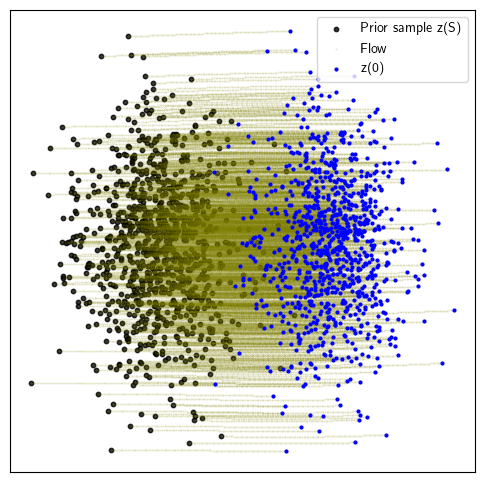

 10%|▉         | 1000/10500 [1:24:13<13:42:33,  5.20s/it]

<Figure size 640x480 with 0 Axes>

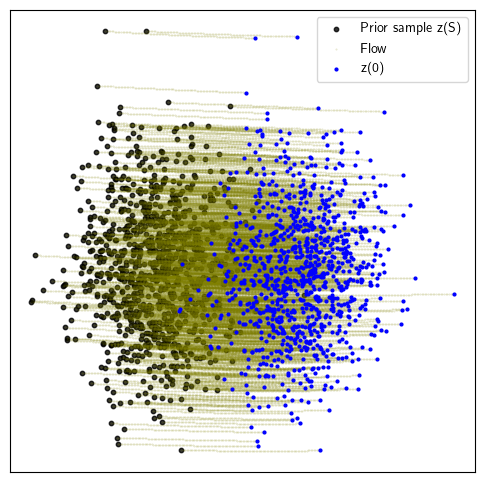

 10%|▉         | 1020/10500 [1:25:58<13:19:01,  5.06s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [49]:
pbar = tqdm(total=n_iters, desc="Training")
writer = SummaryWriter()
for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    t = torch.rand((batch_size,1)).to(device)

    x0 = mu.sample((batch_size,)).to(device)
    x1 = nu.sample((batch_size,)).to(device)

    x0, x1 = ot_sampler.sample_plan(x0, x1)

    # x0_np = np.
    # x1_np = x1

    # with Pool() as p:
    #     results = p.map(solve_bvp, [(i,x0[i].cpu().numpy(), x1[i].cpu().numpy(), t[i].cpu().numpy()) for i in range(batch_size )])
    # # print(results)

    # mu_t, mu_p_t, sigma_t, sigma_p_t = zip(*results)

    # mu_t = np.stack(mu_t,axis=0)
    # mu_p_t = np.stack(mu_p_t,axis=0)
    # sigma_t = np.stack(sigma_t,axis=0)
    # sigma_p_t = np.stack(sigma_p_t,axis=0)

    # print(mu_t,mu_p_t,sigma_t,sigma_p_t)

    # mu_t = torch.tensor(mu_t).float().to(device)
    # mu_t_prime = torch.tensor(mu_p_t).float().to(device)
    # sig_t = torch.tensor(sigma_t).float().to(device).unsqueeze(-1)
    # sig_t_prime = torch.tensor(sigma_p_t).float().to(device).unsqueeze(-1)

    
    
    mu_t,mu_t_prime,sig_t,sig_t_prime = dynam_mu_sig2(t.cpu().numpy(),x0.cpu().numpy(),x1.cpu().numpy(),batch_size)

    mu_t = torch.tensor(mu_t).float().to(device)
    mu_t_prime = torch.tensor(mu_t_prime).float().to(device)
    sig_t = torch.tensor(sig_t).float().to(device).unsqueeze(-1)
    sig_t_prime = torch.tensor(sig_t_prime).float().to(device).unsqueeze(-1)

    epsilon = torch.randn_like(x0).to(device)

    # print(mu_t,epsilon)
    
    xt = mu_t + sig_t*epsilon
    ut = sig_t_prime*(xt-mu_t)/(sig_t+1e-8) + mu_t_prime

    # t,xt,ut = FM.sample_location_and_conditional_flow(x0, x1)

    # print(t.shape,xt.shape,ut.shape)

    vt = model(torch.cat([xt,t],dim = -1))
    # loss = torch.mean(torch.norm(vt - ut)**2)
    loss = torch.nn.MSELoss()(vt,ut)
    writer.add_scalar('Loss', loss.item(), k)

    # Update the progress bar
    pbar.set_description("Loss: %.3f" % loss.item())
    pbar.update()
    

    loss.backward()
    optimizer.step()

    if (k ) % 500 == 0:
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            # print(loss.item())
            traj = node.trajectory(
                mu.sample((1000,)).to(device),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())
            plt.savefig(f"{savedir}/traj_{k}.png")
